## Импорты

In [1]:
import pandas as pd
import numpy as np
import sklearn
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sbn

from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold

# from user_agents import parse

import datetime

from sklearn.tree import DecisionTreeClassifier
from sklearn import grid_search
from sklearn import tree

from sklearn import grid_search
from sklearn.tree import _tree

from sklearn.tree import export_graphviz

import dateutil.parser

import locale
locale.setlocale(locale.LC_ALL, '')

%pylab inline

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Объявления полезных функций

In [2]:
def log_mes(mes):
    """Выводит таймстемп и переданное сообщение"""
    print(datetime.datetime.now().strftime("%H:%M:%S %d.%m.%Y"), mes)

In [3]:
def plot_roc_curve(y, y_pred, color, name):
    fpr_moscow, tpr_moscow, _ = roc_curve(y, y_pred[:, 1])
    roc_auc = roc_auc_score(y, y_pred[:, 1])
    plt.plot(fpr_moscow, tpr_moscow, color=color, lw=2, label='{0} {1:n} samples (AUC = {2:0.4f})'\
             .format(name, len(y), roc_auc))

    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.xticks(arange(6)/5)
    plt.yticks(arange(6)/5)
    plt.grid(linestyle='-')
    
    plt.xlabel('False positive')
    plt.ylabel('True positive')
    plt.legend(loc=4, prop={'size': 20})

In [4]:
def plot_precision_recall(fig, y_test, y_pred, title, i, n):
    subplot = fig.add_subplot(n,1,i)
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:,1])
    plt.step(recall, precision, color='blue', lw=1)
    plt.fill_between(recall, precision, step='pre', alpha=0.2, color='blue')
    plt.ylim([0, 1])
    plt.xlim([0, 1])

    subplot.yaxis.grid()
    subplot.xaxis.grid()
    subplot.set_xticklabels([])
    subplot.set_title(title)

## 1. Чтение выгрузки

In [5]:
metabase_unload = pd.read_csv('unloads/unload.csv', delimiter=",")

In [6]:
# Юзер-агент пока не использую, т.к. он очень долго анализируется
# metabase_unload['device'] = metabase_unload.apply(lambda x: parse(x['user_agent']).device if pd.isnull(x['user_agent']) == False else "None", axis=1)
# metabase_unload['os_version'] = metabase_unload.apply(lambda x: parse(x['user_agent']).os.version if pd.isnull(x['user_agent']) == False else "None", axis=1)
metabase_unload = metabase_unload.drop('user_agent', axis=1)

In [7]:
metabase_unload = metabase_unload.drop(["school_id", "address_entered_before_payment"], axis=1)

In [8]:
metabase_unload["sign_up_date"] = metabase_unload.apply(lambda x: datetime.datetime.fromtimestamp(x['sign_up_date']), axis=1)

In [9]:
metabase_unload.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506192 entries, 0 to 506191
Data columns (total 27 columns):
user_id                             506192 non-null int64
sign_up_date                        506192 non-null datetime64[ns]
days_since_sign_up_passed           506192 non-null float64
paid_on_day_since_sign_up           31554 non-null float64
has_paid_on_sign_up_day             506192 non-null int64
has_paid_in_1_day_after_sign_up     506192 non-null int64
has_paid_in_2_days_after_sign_up    506192 non-null int64
has_paid_in_3_days_after_sign_up    506192 non-null int64
has_paid_in_4_days_after_sign_up    506192 non-null int64
has_paid_in_5_days_after_sign_up    506192 non-null int64
has_paid_in_6_days_after_sign_up    506192 non-null int64
has_paid_in_7_day_after_sign_up     506192 non-null int64
reg_page                            394546 non-null object
reason                              48887 non-null float64
teacher                             48887 non-null float64
time

### Оценим количество зарегистрировавшихся пользователей по месяцам

In [10]:
monthly = metabase_unload.copy()
monthly["month"] = monthly.apply(lambda x: (x['sign_up_date'] - dateutil.relativedelta.relativedelta(day=1)).date(), axis=1)
monthly = monthly.groupby(['month']).size().to_frame('size').reset_index()

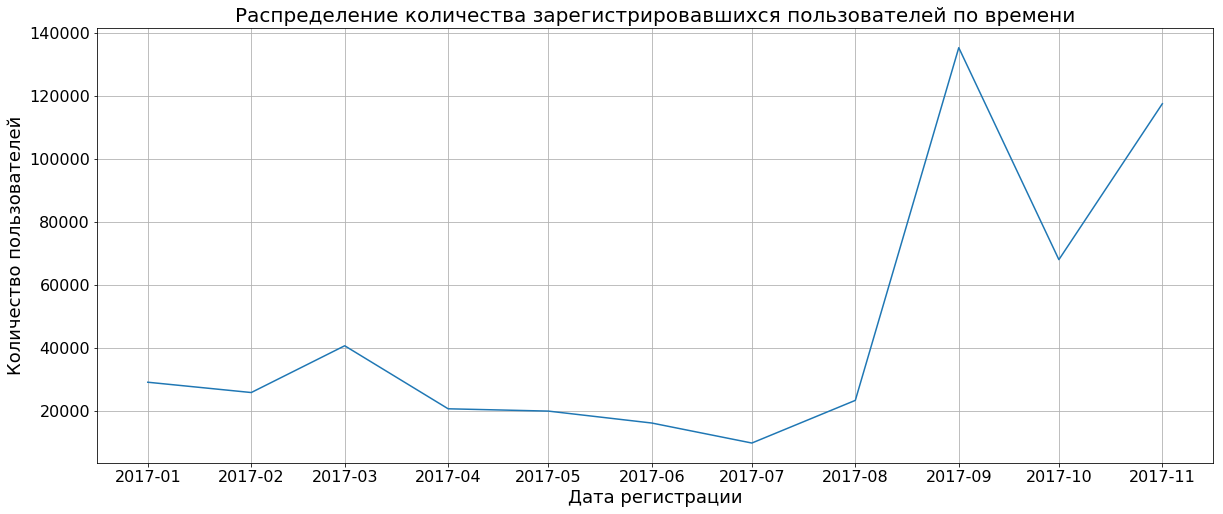

In [11]:
fig = plt.figure(figsize=(20,8))

ax = fig.gca()
ax.xaxis_date()
ax.tick_params(labelsize = 16)
plt.xlabel('Дата регистрации', fontsize=18)
plt.ylabel('Количество пользователей', fontsize=18)
ax.set_yticks(range(0, 160000, 20000))
plt.plot(monthly['month'], monthly['size'])
plt.grid()
plt.title('Распределение количества зарегистрировавшихся пользователей по времени', fontsize=20)
plt.title
plt.show()

## 2. Создание модели

In [12]:
class Model:
    def __init__(self, target_variable):
        self._target_variable = target_variable
        self._init_values()
        
        
    def fit(self, X_train, y_train):
        """
        1. Counts woe's 
        2. Binarieses category columns
        3. Fits XGBoost classifier
        """
        self._model_has_been_fit = False
        self._init_values()
        self._X_train = X_train
        self._y_train = y_train
        self._count_all_woe()
        self._create_and_fit_model()
        self._model_has_been_fit = True
        return self
        
    def predict_proba(self, X_test):
        """
        Predicts probability of target column
        """
        if not self._model_has_been_fit:
            raise RuntimeError("Model has not been fit. Prediction is impossible.")
            
        self._X_test = X_test
        return self._predict_proba()
        
    def plot_importance(self):
        """
        Plots XGBoost feature importance
        """
        if not self._model_has_been_fit:
            raise RuntimeError("Model has not been fit. Plotting is impossible.")

            fig = plt.figure(figsize=(15, 10))
        xgb.plot_importance(booster=self._model)    
    
    def get_tree(self, depht):
        """
        Fits decision tree classifier and returns graphviz tree in text
        """
        if not self._model_has_been_fit:
            raise RuntimeError("Model has not been fit. Drawing tree is impossible.")

        tree_clf = DecisionTreeClassifier(max_depth=depht)
        tree_clf.fit(self._X_train, self._y_train)
        return (export_graphviz(tree_clf, out_file=None, filled=True, feature_names=list(self._X_train.columns)))
    
    def _init_values(self):
        self._woe_dataframes = {}
        self._model_has_been_fit = False
    
    def _create_and_fit_model(self):
        self._X_train = self._transform_dataframe(self._X_train)

        # Модель
        self._model = xgb.XGBClassifier()
        self._model.fit(self._X_train, self._y_train)
        
    def _predict_proba(self):
        self._X_test = self._transform_dataframe(self._X_test)

        return self._model.predict_proba(self._X_test)

    def _count_all_woe(self):
        # Считаем woe-колонки
        woe_columns = ['source_group_id', 'region_id', 'reg_page', 'reason', 'teacher', 'time', 'best_statement']
        for column in woe_columns:
            self._count_woe(column)
    
    def _transform_dataframe(self, X):
        X = self._join_woe(X)
        X = self._drop_user_and_target(X)
        X = self._binarize_category_cols(X)
        return X

    def _drop_user_and_target(self, X):
        columns_to_drop = ['user_id', 'sign_up_date', 'has_paid_on_sign_up_day', \
                           'has_paid_in_1_day_after_sign_up', 'has_paid_in_2_days_after_sign_up',\
                           'has_paid_in_3_days_after_sign_up', 'has_paid_in_4_days_after_sign_up',\
                           'has_paid_in_5_days_after_sign_up', 'has_paid_in_6_days_after_sign_up',\
                           'has_paid_in_7_day_after_sign_up', 'days_since_sign_up_passed',\
                           'paid_on_day_since_sign_up']
        if not self._target_variable in columns_to_drop:
            columns_to_drop.append(self._target_variable)
        return X.drop(columns_to_drop, axis = 1)
    
    def _binarize_category_cols(self, X):
        category_cols = ['grade_id']
        return pd.get_dummies(X, columns=category_cols, drop_first=True)
        
    def _count_woe(self, column_name):
        """
        Counts woe for passed column name in train dataset.
        Result stores in self._woe_dataframes
        """
        threshold = 100

        # расчет общего количества положительных и отрицательных событий
        paid_size = len(self._X_train[self._X_train[self._target_variable] == 1])
        not_paid_size = len(self._X_train[self._X_train[self._target_variable] == 0])

        # имя колонки, в которую будет помещен результат расчета
        woe_column_name = column_name + '_woe'

        # расчет общего количества пользователей и количества положительных событий для каждой категории
        woe_ds = self._X_train\
            .groupby([column_name])\
            .agg({'user_id':'size', self._target_variable:'sum'})\
            .reset_index()\
            .rename(columns={'user_id':'total'})

        # отсекаем категории, в которых количество пользователей не превышает 100 и категории, 
        # в которых нет ни одного положительного события
        woe_ds = woe_ds[(woe_ds['total'] > threshold) & (woe_ds[self._target_variable] > 0)]

        # расчитываем количество отрицательных событий для каждой из категорий
        woe_ds['has_not_paid'] = woe_ds.apply(lambda x: x.total - x[self._target_variable], axis=1)

        # рассчитываем WOE
        woe_ds["woe_value"] = woe_ds\
            .apply(lambda x: math.log((x[self._target_variable]/paid_size)/(x.has_not_paid/not_paid_size)), axis=1)

        # удаляем промежуточные колонки для расчета
        woe_ds = woe_ds.drop([self._target_variable, 'has_not_paid', 'total'], axis=1)

        self._woe_dataframes[column_name] = woe_ds
        
    def _join_woe(self, X):
        """
        Joins woe from self._woe_dataframes to passed dataset
        """
        for column_name, woe_df in self._woe_dataframes.items():
            woe_column_name = column_name + '_woe'
            
            # джоиним woe
            rename = {'woe_value': woe_column_name}
            X = X.merge(woe_df.rename(columns=rename), how='left', left_on=column_name, right_on=column_name)
            
            # удаляем старую категориальную колонку
            X = X.drop(column_name, axis=1)
            
            # заполняем незаполненные значения медианами
            median = np.median(X[woe_column_name].dropna())
            X[woe_column_name] = X[woe_column_name].fillna(median)

        return X

In [13]:
def validation_pipeline(df, splits=3, shuffle=False, random_state=None):
    """
    Doing cross-validation
    """
    target_column = 'has_paid_in_7_day_after_sign_up'
    
    # Выделяем целевую переменную
    y = df[target_column]
    X = df

    # строим кросс-валидацию
    kfold = KFold(n_splits=splits,shuffle=shuffle,random_state=random_state)
    
    log_mes('Validation begins')
    
    # обходим получившиеся сэмплы
    s_num = 1
    for train_index, test_index in kfold.split(X):
        # создаем сэмплы для теста и трейна
        X_train = X.loc[train_index]
        X_test = X.loc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # создаем и обучаем модель
        model = Model(target_column)
        model.fit(X_train, y_train)

        # делаем предсказание
        y_test_pred = model.predict_proba(X_test)

        # считаем roc-auc
        roc_auc_test = roc_auc_score(y_test, y_test_pred[:,1])
        log_mes('Sample {0}. AUC = {1}'.format(s_num, roc_auc_test))
        
        s_num += 1
        
    log_mes('Validation finished')

## 3. Запуск и анализ результатов модели на всей выборке со случайным разделением на тренировочную и тестовую выборку

### 3.1. Сначала проведем кросс-валидацию и убедимся, что модель устойчива

In [14]:
validation_pipeline(metabase_unload, splits=4, shuffle=True, random_state=42)

11:39:49 02.12.2017 Validation begins
11:40:06 02.12.2017 Sample 1. AUC = 0.8853019008075453
11:40:22 02.12.2017 Sample 2. AUC = 0.8845805126228532
11:40:39 02.12.2017 Sample 3. AUC = 0.8847284769189077
11:40:57 02.12.2017 Sample 4. AUC = 0.8829390371652897
11:40:57 02.12.2017 Validation finished


### 3.2. Сформируем случайный тестовый набор данных

In [15]:
target_column = 'has_paid_in_7_day_after_sign_up'

# Выделяем целевую переменную
y = metabase_unload[target_column]
X = metabase_unload


# Делим на train и test
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

### 3.3. Обучим модель и сделаем предсказание

In [16]:
model_random = Model(target_column)
model_random.fit(X_train, y_train)

y_test_pred = model_random.predict_proba(X_test)
y_train_pred = model_random.predict_proba(X_train)

### 3.4. Выведем результаты на roc-кривую

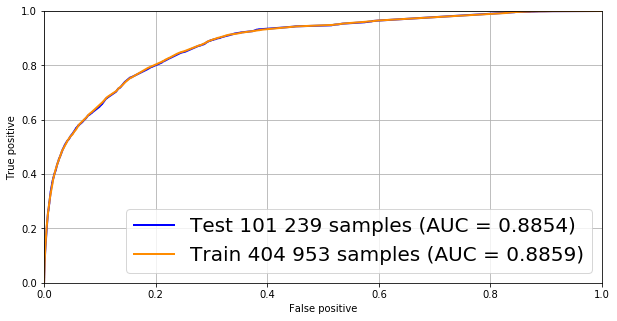

In [17]:
fig = plt.figure(figsize=(10, 5))
plot_roc_curve(y_test, y_test_pred, 'blue', 'Test')
plot_roc_curve(y_train, y_train_pred, 'darkorange', 'Train')

### 3.5. Выведем результаты на кривую Precision-Recall

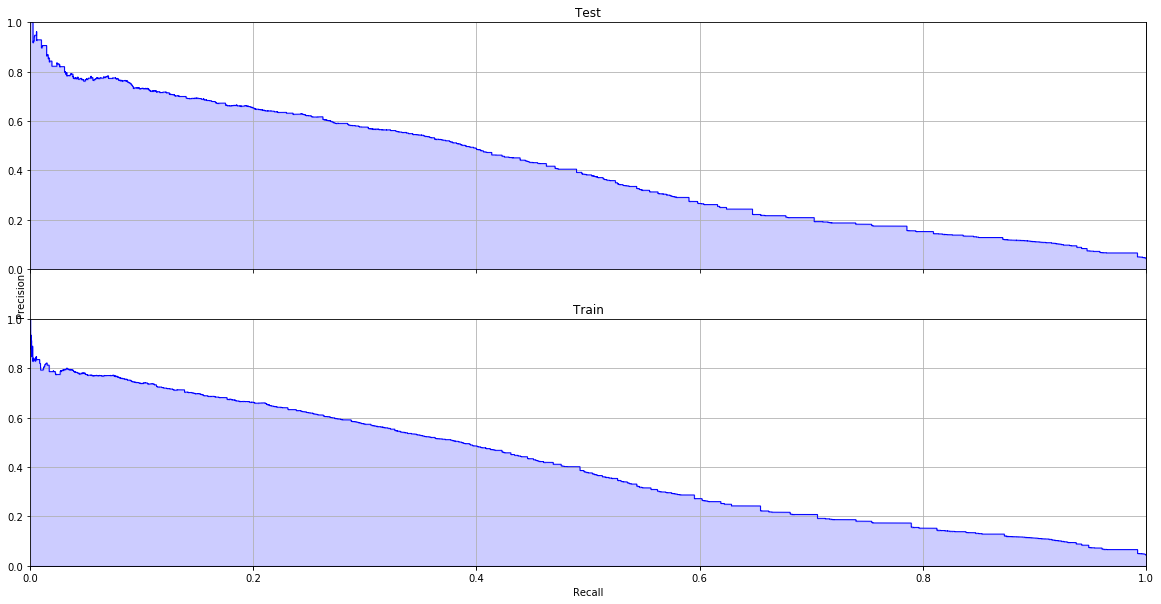

In [18]:
fig = plt.figure(figsize=[20, 10])
ax = plt.axes()
ax.set_yticks([])
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

plot_precision_recall(fig, y_test, y_test_pred, 'Test', 1, 2)
plot_precision_recall(fig, y_train, y_train_pred, 'Train', 2, 2)

### 3.6. Выведем важность фич

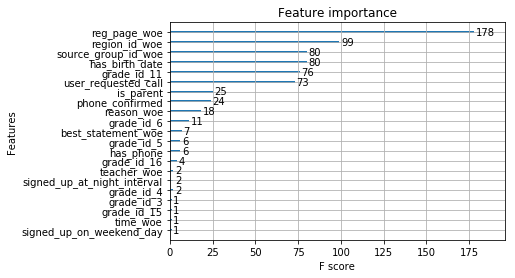

In [19]:
model_random.plot_importance()

### 3.7. Формирование дерева решений для graphviz
http://www.webgraphviz.com/

In [20]:
print(model_random.get_tree(5))

digraph Tree {
node [shape=box, style="filled", color="black"] ;
0 [label="region_id_woe <= 2.317\ngini = 0.08\nsamples = 404953\nvalue = [388035, 16918]", fillcolor="#e58139f4"] ;
1 [label="reg_page_woe <= 1.841\ngini = 0.063\nsamples = 395603\nvalue = [382800, 12803]", fillcolor="#e58139f6"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="region_id_woe <= 2.294\ngini = 0.054\nsamples = 387829\nvalue = [377054, 10775]", fillcolor="#e58139f8"] ;
1 -> 2 ;
3 [label="grade_id_11 <= 0.5\ngini = 0.318\nsamples = 8676\nvalue = [6958, 1718]", fillcolor="#e58139c0"] ;
2 -> 3 ;
4 [label="user_requested_call <= 0.5\ngini = 0.131\nsamples = 4307\nvalue = [4004, 303]", fillcolor="#e58139ec"] ;
3 -> 4 ;
5 [label="gini = 0.061\nsamples = 3579\nvalue = [3467, 112]", fillcolor="#e58139f7"] ;
4 -> 5 ;
6 [label="gini = 0.387\nsamples = 728\nvalue = [537, 191]", fillcolor="#e58139a4"] ;
4 -> 6 ;
7 [label="reg_page_woe <= -0.476\ngini = 0.438\nsamples = 4369\nvalue = [2954, 1415]

### 3.8. Промежуточные итоги
Модель показывает устойчивые результаты на всей выборке. Roc-кривая и кривая precision-recall говорят о хорошей вероятности предсказания целевого события. <br>
Наиболее важные признаки для XGBoost: страница регистрации, регион и канал продвижения.<br>
Дерево принятия решений показывает несколько другой список важных признаков. С XGBoost совпали страница регистрации и регион, но в другом порядке.

### 4.Тестирование на временном сэмпле
Теперь попробуем предсказать оплативших клиентов за 7 дней, которые закончились 7 дней назад, то есть самых последних клиетнов, по которым уже известна целевая переменная.

In [34]:
# определяем граничные даты тестового интервала
max_reg_date = metabase_unload["sign_up_date"].max()
test_begin_date = max_reg_date - datetime.timedelta(days=14)
test_end_date = max_reg_date - datetime.timedelta(days=7)

### 4.1. Попробуем предсказать, что клиент оплатит прям в день регистрации

In [39]:
target_column = 'paid_in_7_days'
X_new = metabase_unload.copy()
X_new[target_column] = X_new.apply(lambda x: 1 if x['paid_on_day_since_sign_up'] == 0 else 0, axis=1)

X_train = X_new[X_new["sign_up_date"] < edge_date1]
X_test = X_new[(X_new["sign_up_date"] >= edge_date1) & (X_new["sign_up_date"] < edge_date2)]

y_train = X_train[target_column]
y_test = X_test[target_column]

# X_train = X_train.drop(target_column, axis=1)
# X_test = X_test.drop(target_column, axis=1)

model_time = Model(target_column)
model_time.fit(X_train, y_train)

y_test_pred = model_time.predict_proba(X_test)
y_train_pred = model_time.predict_proba(X_train)

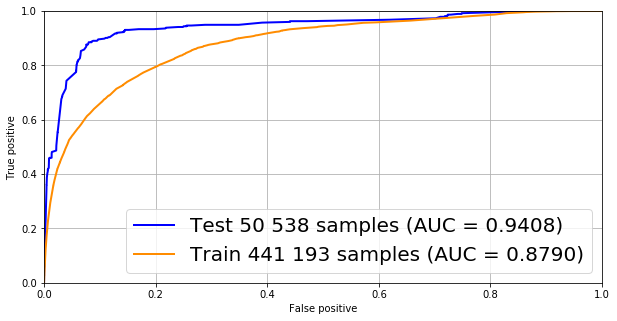

In [40]:
fig = plt.figure(figsize=(10, 5))
plot_roc_curve(y_test, y_test_pred, 'blue', 'Test')
plot_roc_curve(y_train, y_train_pred, 'darkorange', 'Train')

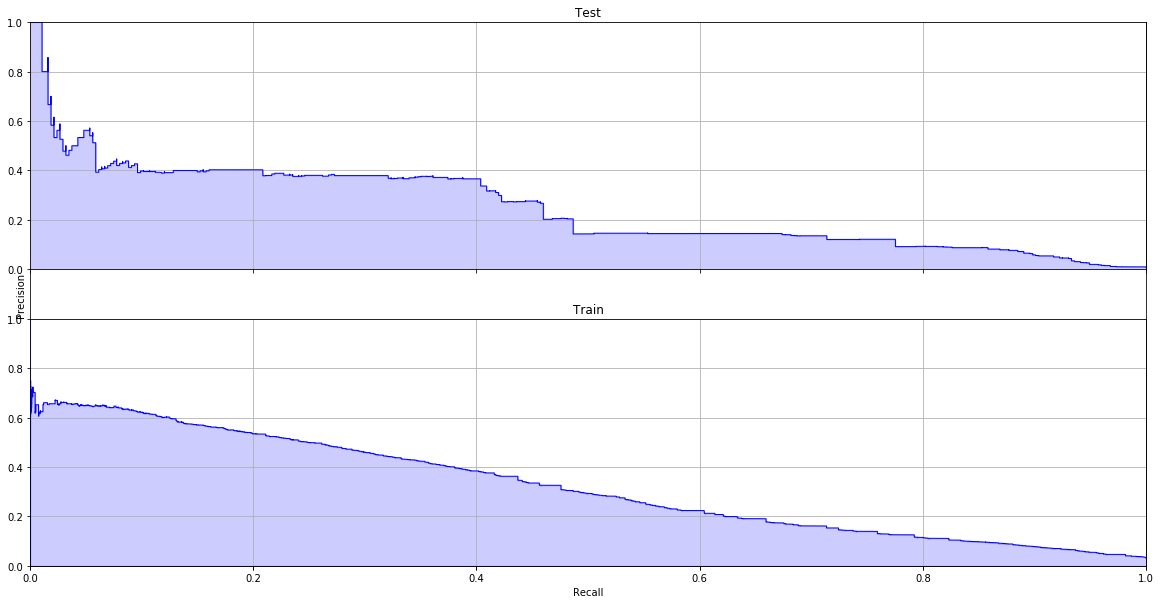

In [41]:
fig = plt.figure(figsize=[20, 10])
ax = plt.axes()
ax.set_yticks([])
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

plot_precision_recall(fig, y_test, y_test_pred, 'Test', 1, 2)
plot_precision_recall(fig, y_train, y_train_pred, 'Train', 2, 2)

### 4.2. Теперь попробуем предсказать, что клиент оплатит во второй день после регистрации

In [42]:
target_column = 'paid_in_7_days'
X_new = metabase_unload.copy()
X_new[target_column] = X_new.apply(lambda x: 1 if x['paid_on_day_since_sign_up'] == 1 else 0, axis=1)

X_train = X_new[X_new["sign_up_date"] < edge_date1]
X_test = X_new[(X_new["sign_up_date"] >= edge_date1) & (X_new["sign_up_date"] < edge_date2)]

y_train = X_train[target_column]
y_test = X_test[target_column]

# X_train = X_train.drop(target_column, axis=1)
# X_test = X_test.drop(target_column, axis=1)

model_time = Model(target_column)
model_time.fit(X_train, y_train)

y_test_pred = model_time.predict_proba(X_test)
y_train_pred = model_time.predict_proba(X_train)

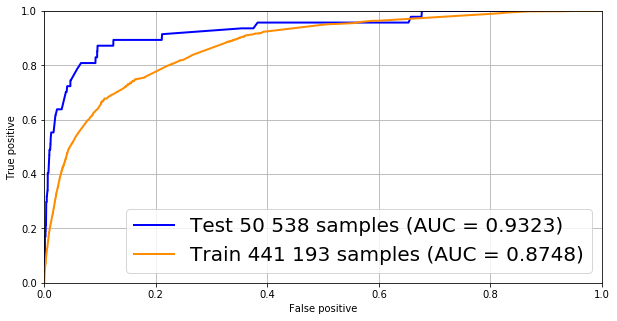

In [43]:
fig = plt.figure(figsize=(10, 5))
plot_roc_curve(y_test, y_test_pred, 'blue', 'Test')
plot_roc_curve(y_train, y_train_pred, 'darkorange', 'Train')

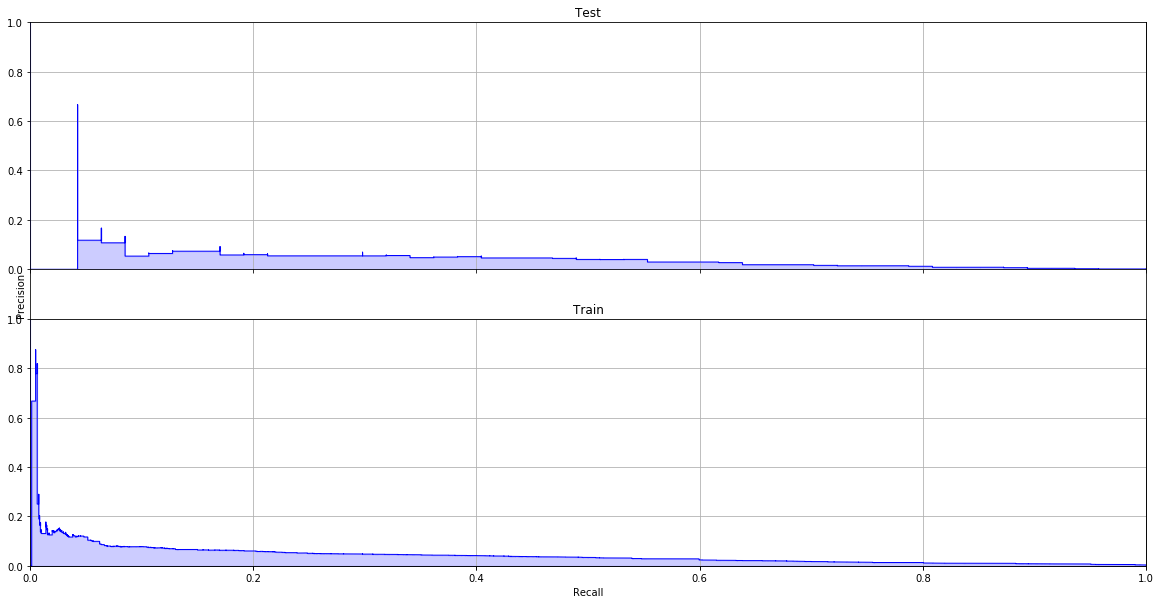

In [44]:
fig = plt.figure(figsize=[20, 10])
ax = plt.axes()
ax.set_yticks([])
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

plot_precision_recall(fig, y_test, y_test_pred, 'Test', 1, 2)
plot_precision_recall(fig, y_train, y_train_pred, 'Train', 2, 2)

## Дальше не смотри

In [33]:
reg_woe = model_time._woe_dataframes["region_id"]

In [34]:
reg_woe[(reg_woe["woe_value"] >= 2.151) & (reg_woe["woe_value"] <=2.162)].sort_values('woe_value', ascending=False)

,region_id,woe_value
57,58.0,2.158066


In [31]:
def plot_roc_curve_no_color(y, y_pred, name):
    fpr_moscow, tpr_moscow, _ = roc_curve(y, y_pred[:, 1])
    roc_auc = roc_auc_score(y, y_pred[:, 1])
    plt.plot(fpr_moscow, tpr_moscow, lw=2, label='{0} {1:n} samples (AUC = {2:0.4f})'\
             .format(name, len(y), roc_auc))

    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.xticks(arange(6)/5)
    plt.yticks(arange(6)/5)
    plt.grid(linestyle='-')
    
    plt.xlabel('False positive')
    plt.ylabel('True positive')
    plt.legend(loc=4, prop={'size': 15})

In [32]:
# has_paid_on_registraion_day         503954 non-null int64
# has_paid_in_1_day_after_sign_up     503954 non-null int64

# target_column = 'has_paid_on_registraion_day'

def predict_proba(X, edge_date, days_forward, target_column):
    X_test = X[(metabase_unload["sign_up_date"] >= edge_date) & (X["sign_up_date"] < (edge_date + datetime.timedelta(days=days_forward)))]
    y_test = X_test[target_column]

    X_train = X[metabase_unload["sign_up_date"] < edge_date]
    y_train = X_train[target_column]

    model_time = Model(target_column)
    model_time.fit(X_train, y_train)

    y_test_pred = model_time.predict_proba(X_test)
    y_train_pred = model_time.predict_proba(X_train)

    fig = plt.figure(figsize=(10, 5))
    plot_roc_curve_no_color(y_test, y_test_pred, target_column)

In [25]:
max_reg_date = metabase_unload["sign_up_date"].max()
edge_date = max_reg_date - datetime.timedelta(days=14)
edge_date

Timestamp('2017-11-13 22:11:15.717435')

In [34]:
target_columns = ['has_paid_on_registraion_day', 'has_paid_in_1_day_after_sign_up', \
                  'has_paid_in_2_days_after_sign_up', 'has_paid_in_3_days_after_sign_up', \
                  'has_paid_in_4_days_after_sign_up', 'has_paid_in_5_days_after_sign_up', \
                  'has_paid_in_6_days_after_sign_up', 'has_paid_in_7_day_after_sign_up']

In [22]:
day_of_payment = 0
X = metabase_unload.copy()
column_name = "paid_on_day_" + str(day_of_payment)
X[column_name] = X.apply(lambda x: 1 if x["paid_on_day_since_sign_up"] == day_of_payment else 0, axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506192 entries, 0 to 506191
Data columns (total 28 columns):
user_id                             506192 non-null int64
sign_up_date                        506192 non-null datetime64[ns]
days_since_sign_up_passed           506192 non-null float64
paid_on_day_since_sign_up           31554 non-null float64
has_paid_on_sign_up_day             506192 non-null int64
has_paid_in_1_day_after_sign_up     506192 non-null int64
has_paid_in_2_days_after_sign_up    506192 non-null int64
has_paid_in_3_days_after_sign_up    506192 non-null int64
has_paid_in_4_days_after_sign_up    506192 non-null int64
has_paid_in_5_days_after_sign_up    506192 non-null int64
has_paid_in_6_days_after_sign_up    506192 non-null int64
has_paid_in_7_day_after_sign_up     506192 non-null int64
reg_page                            394546 non-null object
reason                              48887 non-null float64
teacher                             48887 non-null float64
time

In [23]:
days_forward = 1
column_name = 'has_paid_on_sign_up_day'

In [26]:
X_test = X[(X["sign_up_date"] >= edge_date) & (X["sign_up_date"] < (edge_date + datetime.timedelta(days=days_forward)))]
y_test = X_test[column_name]
y_test.sum()

78

In [27]:

X_train = X[X["sign_up_date"] < edge_date]
y_train = X_train[column_name]


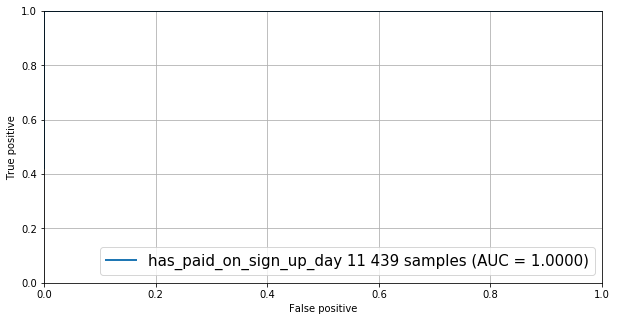

In [32]:

model_time = Model(column_name)
model_time.fit(X_train, y_train)

y_test_pred = model_time.predict_proba(X_test)
y_train_pred = model_time.predict_proba(X_train)

fig = plt.figure(figsize=(10, 5))
plot_roc_curve_no_color(y_test, y_test_pred, column_name)

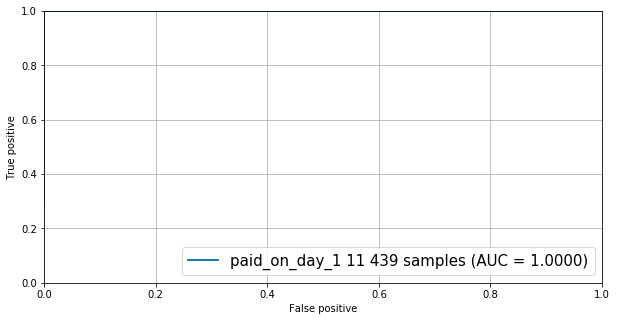

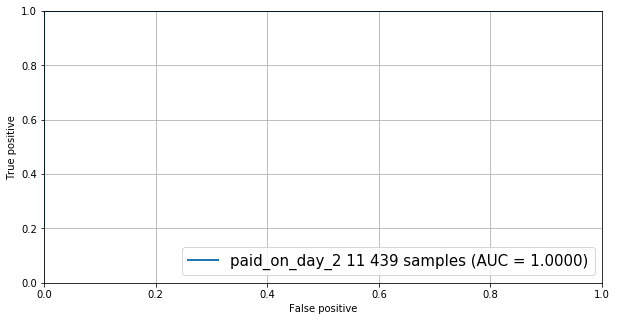

In [35]:
for day_of_payment in range(1, 3):
    X = metabase_unload.copy()
    column_name = "paid_on_day_" + str(day_of_payment)
    X[column_name] = X.apply(lambda x: x["paid_on_day_since_sign_up"] == day_of_payment, axis=1)
    predict_proba(X, edge_date, 1, column_name)


In [14]:
grouped = metabase_unload.groupby(['has_paid_on_registraion_day', 'has_paid_in_1_day_after_sign_up', \
                      'has_paid_in_2_days_after_sign_up', 'has_paid_in_3_days_after_sign_up', \
                      'has_paid_in_4_days_after_sign_up', 'has_paid_in_5_days_after_sign_up', \
                      'has_paid_in_6_days_after_sign_up', 'has_paid_in_7_day_after_sign_up'])\
            .size().to_frame('size').reset_index()
grouped

,has_paid_on_registraion_day,has_paid_in_1_day_after_sign_up,has_paid_in_2_days_after_sign_up,has_paid_in_3_days_after_sign_up,has_paid_in_4_days_after_sign_up,has_paid_in_5_days_after_sign_up,has_paid_in_6_days_after_sign_up,has_paid_in_7_day_after_sign_up,size
0,0,0,0,0,0,0,0,0,482902
1,0,0,0,0,0,0,0,1,584
2,0,0,0,0,0,0,1,1,759
3,0,0,0,0,0,1,1,1,719
4,0,0,0,0,1,1,1,1,825
5,0,0,0,1,1,1,1,1,906
6,0,0,1,1,1,1,1,1,1087
7,0,1,1,1,1,1,1,1,1466
8,1,1,1,1,1,1,1,1,14706


## Следующие задачи
1. Обучить и сделать предсказания для временного сэмпла
2. Уменьшить интервал трейна для временного интервала настолько насколько получится без последствий для точности
3. Попытаться сделать предсказание отдельно для пользователей, у которых введен телефон и для пользователей, у которых не введен. Сравнить получившиеся предсказания с предсказаниями без разделения.
4. Добавить в фичи пол. Пол определить по именам и фамилиям.

* ROC-AUC
6. Feature importance
7. Дерево принятия решений
1. Выводить предикт на трейн
2. Кросс-валидация
4. Взять данные за год и смотрим не упадет ликачество модели
5. брать данные за 4 месяца и предсказать 2 недели
8. Порог отсечения
9. Определить имена и фамилии
11. Зафитить только людей, у которых нет телефонов
12. Зафитить только людей, у которых есть телефоны